# Convert weather station CSV files to parquet

In [1]:
import os
from pprint import pprint
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_columns(file, nlines):
    with open(file) as f:
        lines = [f.readline() for _ in range(nlines)]
        texts = [[text.strip(' .\n') for text in line.split('\t')] for line in lines]
        columns = ['_'.join(x).lstrip('_') for x in zip(*texts)]
    return columns

In [3]:
srcdir = 'data/src/wx'
dstdir = 'data/dst'

In [4]:
# ** weather data ***
ext = '.txt'

files = [file for file in os.listdir(srcdir) if file.endswith(ext)]
print(f'Found {len(files)} files:')
pprint(files)

Found 19 files:
['2006.txt',
 '2007.txt',
 '2008.txt',
 '2009.txt',
 '2010.txt',
 '2011.txt',
 '2012.txt',
 '2013.txt',
 '2014.txt',
 '2015.txt',
 '2016.txt',
 '2017.txt',
 '2018.txt',
 '2019.txt',
 '2020.txt',
 'WXdata-3-28-24.txt',
 'WXdata2021.txt',
 'WXdata2022.txt',
 'WXdata2023.txt']


In [5]:
datasets = []

for file in files:
    
    fn = f'{srcdir}/{file}'
    
    columns = get_columns(fn, 2)
    raw = pd.read_csv(fn, skiprows=2, header=0, names=columns, parse_dates=False, na_values=['#VALUE!','---','------'], sep='\t', low_memory=False)

    # Time zone is unknown so we have only naive datetime or assume UTC,
    # 2008.txt contains duplicate datetimes at 2008-03-10 and 2008-05-07
    raw['Time'] = raw['Time'] + 'm'
    raw['DateTimeLocal'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'], format='%m/%d/%y %I:%M %p', utc=False)
    raw['DateTimeLocal'] = raw['DateTimeLocal'].dt.tz_localize('EST')

    # will convert the local to UTC in the DateTime later
    raw['DateTime'] = raw['DateTimeLocal']
    raw.drop(['Date', 'Time'], axis=1, inplace=True)

    # check for duplicates in the individual files
    print('Loaded:', fn, 'Removing duplicate DateTimes:', raw['DateTimeLocal'].duplicated().any())

    # not actually sure which of the duplicates we want
    df = raw.loc[~raw['DateTimeLocal'].duplicated(), :]
    
    datasets.append(df)

Loaded: data/src/wx/2006.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2007.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2008.txt Removing duplicate DateTimes: True
Loaded: data/src/wx/2009.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2010.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2011.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2012.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2013.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2014.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2015.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2016.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2017.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2018.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2019.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/2020.txt Removing duplicate DateTimes: False
Loaded: data/src/wx/WXdata

In [6]:
# concatenate the dataframes
wx_df = pd.concat(datasets)
wx_df.shape

(566870, 36)

In [7]:
# any DateTime duplicates after concatenation?
wx_df['DateTime'].duplicated().any()

np.False_

In [8]:
# if no duplicates go ahead and set the frequency
wx_df.set_index(wx_df['DateTime'], inplace=True)

# leave the frequency alone for now...
#in_freq = pd.infer_freq(wx_df.index)

#wx_df = wx_df.asfreq(freq=in_freq)
wx_df = wx_df.asfreq(freq='15min')

# maybe resample later
# wx_df = wx_df.resample('1min').first().interpolate().resample(to_freq).asfreq()
# wx_df = wx_df.resample('15min').first()

# update the index to UTC
wx_df.index = wx_df.index.tz_convert(pytz.utc)

In [9]:
wx_df.index

DatetimeIndex(['2006-06-09 01:45:00+00:00', '2006-06-09 02:00:00+00:00',
               '2006-06-09 02:15:00+00:00', '2006-06-09 02:30:00+00:00',
               '2006-06-09 02:45:00+00:00', '2006-06-09 03:00:00+00:00',
               '2006-06-09 03:15:00+00:00', '2006-06-09 03:30:00+00:00',
               '2006-06-09 03:45:00+00:00', '2006-06-09 04:00:00+00:00',
               ...
               '2024-03-28 10:30:00+00:00', '2024-03-28 10:45:00+00:00',
               '2024-03-28 11:00:00+00:00', '2024-03-28 11:15:00+00:00',
               '2024-03-28 11:30:00+00:00', '2024-03-28 11:45:00+00:00',
               '2024-03-28 12:00:00+00:00', '2024-03-28 12:15:00+00:00',
               '2024-03-28 12:30:00+00:00', '2024-03-28 12:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DateTime', length=624237, freq='15min')

2006-06-09 01:45:00+00:00 2024-03-28 12:45:00+00:00


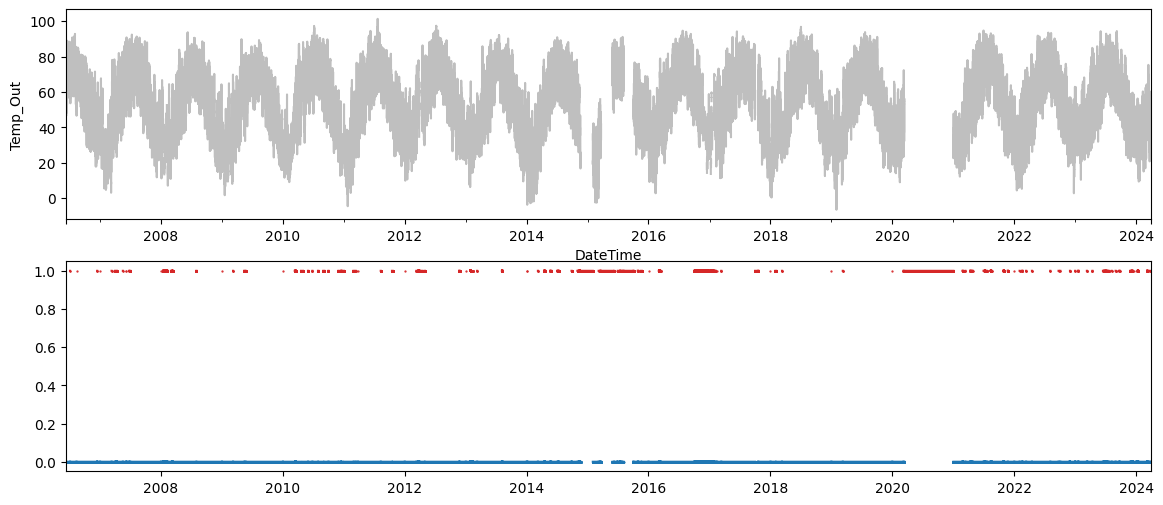

In [10]:
col = 'Temp_Out'

fig, ax = plt.subplots(2,1)
fig.set_size_inches(14,6)

start = wx_df.first_valid_index()
stop = wx_df.last_valid_index()
print(start, stop)

wx_df[start:stop][col].plot(ax=ax[0], color='gray', alpha=0.5)

# add some nodata marks
mask = pd.isnull(wx_df[start:stop][col])

ax[1].plot(mask.index, mask.mask(mask == False),
         color='tab:red', marker='.', markersize=1.2,
         label='nodata')
ax[1].plot(mask.index, mask.mask(mask == True),
         color='tab:blue', marker='.', markersize=1.2,
         label='data')
ax[1].set_xlim(start, stop)

ax[0].set_ylabel(f'{col}')
plt.show()

In [11]:
# write to parquet file
print(f'Writing: wx_data.parquet')
wx_df.to_parquet(f'{dstdir}/wx_data.parquet', index=True)

Writing: wx_data.parquet
